**Gordon Doore and Ghailan Fadah**

Spring 2024

CS 443: Bio-inspired Machine Learning

#### Week 3: Decode MNIST class labels from Competitive Hebbian Network activations

# Project 1: Hebbian Learning

You will use single layer artificial neural networks to **decode** (i.e. predict) the digit class label corresponding to each MNIST sample **encoded** (i.e. processed) by your Competitive Hebbian Network. This will take advantage of the Competitive Hebbian Network weights that you saved off last week. Once you obtain the Competitive Hebbian Network activations, you will predict the MNIST labels and compute the MNIST classification accuracy obtained by this **encoder-decoder** neural network architecture.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

2024-03-08 18:22:22.134136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 3: Decoder networks

In this task, you will create two specific single layer neural networks that will be trained to decode the MNIST digit associated with each sample, encoded as an array of `H` activations produced by the Competitive Hebbian Network. The two single layer networks will be:
1. Softmax (linear) decoder
2. Tanh (nonlinear) decoder

Remember that "decoder" refers to the *role* of the neural network — the implementation details of the decoder networks are no different than the single layer network you created in Project 0. In fact, this task will rely on substantial copy-pasting from `single_layer_net.py` in Project 0!

In [2]:
from neural_decoder import SoftmaxDecoder

### 3a. Create `NeuralDecoder` and `SoftmaxDecoder` classes in `neural_decoder.py`

1. Copy-paste your `SingleLayerNetwork` and `SoftmaxNet` classes from `single_layer_net.py` in Project 0.
2. Rename `SingleLayerNetwork` as `NeuralDecoder`.
3. Rename `SoftmaxNet` as `SoftmaxDecoder`.
4. Place the provided docstring and `early_stopping` method stub in the `NeuralDecoder` class.
5. Replace the docstring and method signature of your `fit` method (**but KEEP your existing fit code**) with the one provided in `neural_decoder.py`. The method signature should now look like:<br/> `def fit(self, x, y, x_val=None, y_val=None, mini_batch_sz=512, lr=1e-4, max_epochs=1000, patience=3, val_every=1, verbose=True)`

### 3b. Add support for early stopping in `NeuralDecoder` training

To make determining a reasonable number of epochs when train a neural network less of a chore, implement training with **early stopping**: train and regularly monitor loss on the validation set. If the network has not "broken a new record" in making the validation loss smaller over the recent history, stop training the network. We also limit training to some maximum number of epochs in case we do not stop early to prevent the network possibly training for an unreasonably long time. The number of validation loss values in the recent history that we consider when deciding whether to stop training early is called the **patience**.

#### Todo

Implement or update the following training related methods in the `NeuralDecoder` class (`neural_decoder.py`). These methods are shared among all types of decoder networks (linear, nonlinear).
- Implement `early_stopping(self, recent_val_losses, curr_val_loss, patience)`: Update rolling list of recent validation loss values with the validation loss computed on the current epoch. Return whether we should stop training based on the `patience` hyperparameter value.
- Update `fit`: Integrate early stopping into your training code so that training takes at most `max_epochs` epochs of training, but may stop earlier, depending on the `patience` value.

#### Test `early_stopping`

In [30]:
sd = SoftmaxDecoder(1, 1)

# Test 1
patience_1 = 5
es_lost_hist_1 = []
for iter in range(10):
    curr_loss = float(iter)
    es_lost_hist_1, stop = sd.early_stopping(es_lost_hist_1, curr_loss, patience=patience_1)

    if stop:
        break
print(f'Early stopping Test 1 ({patience_1=}):\n Stopped after {iter} iterations (should be 5 iterations).')
print(f' Recent loss history is {es_lost_hist_1} and should be [1.0, 2.0, 3.0, 4.0, 5.0]')
print()

# Test 2
tf.random.set_seed(1)
patience_2 = 3
es_lost_hist_2 = []
test_2_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_2_loss_vals[iter]
    es_lost_hist_2, stop = sd.early_stopping(es_lost_hist_2, curr_loss, patience=patience_2)

    if stop:
        break
print(f'Early stopping Test 2 ({patience_2=}):\n Stopped after {iter} iterations (should be 6 iterations).')
print(f' Recent loss history is {es_lost_hist_2} and should be [0.29193902, 0.64250207, 0.9757855]')
print()

# Test 3
tf.random.set_seed(1)
patience_3 = 6
es_lost_hist_3 = []
test_3_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_3_loss_vals[iter]
    es_lost_hist_3, stop = sd.early_stopping(es_lost_hist_3, curr_loss, patience=patience_3)

    if stop:
        break
print(f'Early stopping Test 3 ({patience_3=}):\n Stopped after {iter} iterations (should be 9 iterations).')
print(f' Recent loss history is\n {es_lost_hist_3}\n and should be')
print(' [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]')
print()



Early stopping Test 1 (patience_1=5):
 Stopped after 5 iterations (should be 5 iterations).
 Recent loss history is [1.0, 2.0, 3.0, 4.0, 5.0] and should be [1.0, 2.0, 3.0, 4.0, 5.0]

Early stopping Test 2 (patience_2=3):
 Stopped after 6 iterations (should be 6 iterations).
 Recent loss history is [0.29193902, 0.64250207, 0.9757855] and should be [0.29193902, 0.64250207, 0.9757855]

Early stopping Test 3 (patience_3=6):
 Stopped after 9 iterations (should be 9 iterations).
 Recent loss history is
 [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]
 and should be
 [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]



#### Test `fit`

Run the code below to test your fit with early stopping. It loads in the Iris dataset and trains with a patience of `3`.

<!-- Write code in the cell below to:
- Load in Iris training and validation sets (as you have done above for your softmax classifier). For this test, **don't** do any preprocessing (e.g. no normalization).
- Make sure that your train and validation samples are `tf.float32`.
- Create and train a softmax decoder network using the hyperparameters provided below.
- Make a well-labeled plot showing the validation loss over training epochs. -->

Monitor your training progress print outs. If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~0.08. Everyone's epochs until early stopping might be different. Mine stopped after 700 epochs.

In [3]:
tf.random.set_seed(0)  # keep me

# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int64)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int64)

C = 3
M = train_samps.shape[1]

sd = SoftmaxDecoder(M, C)
_, val_loss_hist, num_epochs = sd.fit(train_samps, train_labels, val_samps, val_labels,
                                      batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                      patience=patience, val_every=val_every)


epoch: 0
validation accuracy: 0.6530612244897959
validation loss: 0.8470522
lr: 0.1

epoch: 100
validation accuracy: 0.9795918367346939
validation loss: 0.08492931
lr: 0.1

epoch: 200
validation accuracy: 0.9591836734693877
validation loss: 0.08238907
lr: 0.1

epoch: 300
validation accuracy: 0.9591836734693877
validation loss: 0.07262395
lr: 0.1

epoch: 400
validation accuracy: 0.9591836734693877
validation loss: 0.09617384
lr: 0.1

epoch: 500
validation accuracy: 0.9591836734693877
validation loss: 0.07367293
lr: 0.1
Early stopping initiated for patience = 3
Finished training after 501 epochs!


### 3c. Questions: Effect of early stopping

**Question 7:** Copy-and-paste the training code from the cell above. Change the `patience` hyperparameter. Create at least two plots showcasing the effect. How do increases and decreases affect the duration of training and **why**?

**Question 8:** Explain how the choice of `patience` affects the risk of overfitting. Point out specifics in your plots and/or training history to justify your answer.

**Answer 7:** By increasing the patience we see that it results in longer training time due to doing more epochs since our thershold to stopping early was higher (more patience) thus allowing us to obtain a lower loss and better learning. By decreasing the patience we were able to speed up the training (~300 epochs instead of ~5000) since our thershold for stopping early was tight (less patience).

**Answer 8:** As seen from the plot and results below increasing patience can lead to better learning and lower loss but if set too high it does increase the risk of overfitting. As seen below at about ~600 epochs we obtained the smallest loss value but since our patience was so high it kept training until the max_epoch was hit (~5000) this of course resulted in the loss blowing up resulting in nan values and the accuracy dropping to ~30%

In [ ]:


# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 10
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int64)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int64)

C = 3
M = train_samps.shape[1]

sd = SoftmaxDecoder(M, C)
_, val_loss_hist, num_epochs = sd.fit(train_samps, train_labels, val_samps, val_labels,
                                      batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                      patience=patience, val_every=val_every)


epoch: 0
validation accuracy: 0.6530612244897959
validation loss: 0.8470522
lr: 0.1

epoch: 100
validation accuracy: 0.9795918367346939
validation loss: 0.08492931
lr: 0.1

epoch: 200
validation accuracy: 0.9591836734693877
validation loss: 0.08238907
lr: 0.1

epoch: 300
validation accuracy: 0.9591836734693877
validation loss: 0.07262395
lr: 0.1

epoch: 400
validation accuracy: 0.9591836734693877
validation loss: 0.09617384
lr: 0.1

epoch: 500
validation accuracy: 0.9591836734693877
validation loss: 0.07367293
lr: 0.1

epoch: 600
validation accuracy: 0.9591836734693877
validation loss: 0.08624843
lr: 0.1

epoch: 700
validation accuracy: 0.9795918367346939
validation loss: 0.081055
lr: 0.1

epoch: 800
validation accuracy: 0.9795918367346939
validation loss: 0.08618343
lr: 0.1

epoch: 900
validation accuracy: 0.9795918367346939
validation loss: 0.08487353
lr: 0.1

epoch: 1000
validation accuracy: 0.9591836734693877
validation loss: 0.12064293
lr: 0.1

epoch: 1100
validation accuracy: 0.

Text(0, 0.5, 'loss')

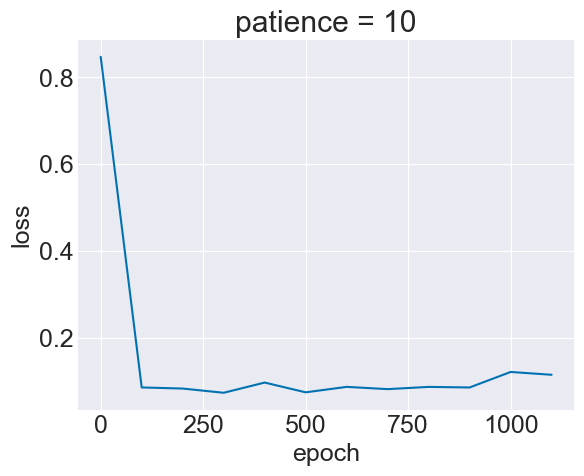

In [ ]:
x = np.arange(0, 5001, 100)
plt.plot(x, val_loss_hist)
plt.title("patience = 10")
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:


# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 2
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int64)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int64)

C = 3
M = train_samps.shape[1]

sd = SoftmaxDecoder(M, C)
_, val_loss_hist, num_epochs = sd.fit(train_samps, train_labels, val_samps, val_labels,
                                      batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                      patience=patience, val_every=val_every)


epoch: 0
validation accuracy: 0.6530612244897959
validation loss: 0.89791894
lr: 0.1

epoch: 100
validation accuracy: 0.9591836734693877
validation loss: 0.08871724
lr: 0.1

epoch: 200
validation accuracy: 0.9591836734693877
validation loss: 0.07768761
lr: 0.1

epoch: 300
validation accuracy: 0.9591836734693877
validation loss: 0.0798196
lr: 0.1
Early stopping initiated for patience = 2
Finished training after 301 epochs!


Text(0, 0.5, 'loss')

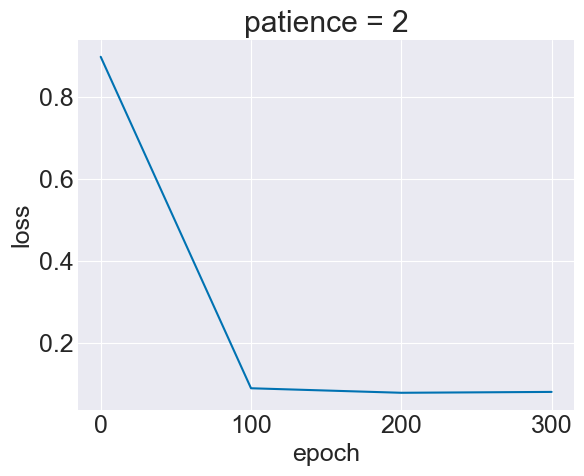

In [ ]:
x = np.arange(0, 301, 100)
plt.plot(x, val_loss_hist)
plt.title("patience = 2")
plt.xlabel("epoch")
plt.ylabel("loss")

### 3d. Implement nonlinear Tanh decoder

Now that you have the softmax decoder implemented, implement in TensorFlow the following nonlinear single layer decoding neural network proposed by Krotov & Hopfield (2019). Make a class `NonlinearDecoder` in `neural_decoder.py` that inherits from `NeuralDecoder`. Implement the following methods in the `NonlinearDecoder` class.
- `__init__(self, num_features, num_classes, wt_stdev=0.1, beta=0.005, loss_exp=5):` Set instance variables for `beta` ($\beta$) and `loss_exp` ($m$). Extend parent class constructor/exploit inheritance. 
- `one_hot(self, y, C)`
- `forward(self, x)`
- `loss(self, yh, net_act)`

**All of these methods should require only a few lines of code each.**
#### Overview of nonlinear Tanh decoding network

$$\text{netIn}_{ic} = \sum_{j=1}^M x_{ij}w_{jc} + b_c$$
$$\text{netAct}_{ic} = tanh(\beta * \text{netIn}_{ic})$$

where:
- the `net_act` function is the hyperbolic tangent function `tanh` (*this is another common net_act function in neural networks*).
- the wts have shape `(M, C)` and the bias has shape `(C,)`.
- the input $x_{ij}$ has the usual shape `(N, M)`.

To predict the class of sample `i` $c_i^*$, use softmax (same as in your softmax network):
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$

The loss function to minimize is:

$$L = \sum_{i=1}^B \sum_{c=1}^C \left | \text{yh}_{ic} - \text{netAct}_{ic} \right |^m$$

where:
- $\text{yh}_{ic}$ is the one-hot coding of the true class of sample `i`. Remember: because we are using the $tanh$ activation function, the "on" value is `1` (like usual), **but the "off" value is `-1`**.
- The exponent `m` is a hyperparameter. The below test code uses the default value (`5`).
- $|\cdot|$ means absolute value.

In [3]:
from neural_decoder import NonlinearDecoder

#### Test: weight and bias initialization

In [ ]:
tf.random.set_seed(1)
M, C = 4, 3
nl = NonlinearDecoder(M, C)
wts = nl.get_wts()
b = nl.get_b()

tf.print(f"Your wts are:\n{wts}\nand it should be:")
print("""<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>""")
tf.print(f"\nYour bias is:\n{b}\nand it should be")
print("<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>")

Your wts are:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>
and it should be:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>

Your bias is:
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.04 ],
       [-0.109],
       [-0.006]], dtype=float32)>
and it should be
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>


#### Test forward

In [ ]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32) + 100

nl_net = NonlinearDecoder(M, C)
nl_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
nl_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_net_act = nl_net.forward(x)

print(f'Your net_act is:\n{test_net_act}')
print('and it should be:')
print("""[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]""")

Your net_act is:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]
and it should be:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]


#### Test loss

In [ ]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)
y = np.array([2, 0, 1, 1])

sm_net = NonlinearDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_yh = sm_net.one_hot(y, C)
test_net_act = sm_net.forward(x)
test_loss = sm_net.loss(test_yh, test_net_act)

print(f'Your loss is {test_loss:.4f} and it should be 11.9857')

Your loss is 11.9857 and it should be 11.9857


#### Test `fit`

**TODO:**

1. Copy-and-paste your code from above that trains the softmax network on Iris below.
2. Modify the code in the cell below to train your Nonlinear decoder instead and make the same plot of the validation loss.
3. Change your `patience` to `2`.

Otherwise, use the same training hyperparameters as you used with the softmax network and default values for the β and `m` (loss exponent) hyperparameters. 

If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~42.80. Everyone's early stopping values might be different. In case it helps to know, mine stopped after 2500 epochs.

In [ ]:
tf.random.set_seed(0)  # keep me

# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 2
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int64)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int64)

C = 3
M = train_samps.shape[1]

sd = NonlinearDecoder(M, C)
train_loss_hist, val_loss_hist, num_epochs = sd.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=patience, val_every=val_every)


epoch: 0
validation accuracy: 0.32653061224489793
validation loss: 142.27356
lr: 0.1

epoch: 100
validation accuracy: 0.8775510204081632
validation loss: 70.96197
lr: 0.1

epoch: 200
validation accuracy: 0.9387755102040817
validation loss: 61.43081
lr: 0.1

epoch: 300
validation accuracy: 0.9387755102040817
validation loss: 56.89109
lr: 0.1

epoch: 400
validation accuracy: 0.8775510204081632
validation loss: 54.844814
lr: 0.1

epoch: 500
validation accuracy: 0.9387755102040817
validation loss: 52.199913
lr: 0.1

epoch: 600
validation accuracy: 0.9795918367346939
validation loss: 50.484486
lr: 0.1

epoch: 700
validation accuracy: 0.9795918367346939
validation loss: 49.16333
lr: 0.1

epoch: 800
validation accuracy: 0.9795918367346939
validation loss: 48.047756
lr: 0.1

epoch: 900
validation accuracy: 0.9795918367346939
validation loss: 47.595768
lr: 0.1

epoch: 1000
validation accuracy: 0.9795918367346939
validation loss: 46.4298
lr: 0.1

epoch: 1100
validation accuracy: 0.9795918367346

### 3e. Effect of β and loss exponent

Using the Iris dataset again, make high-quality, well-labeled plots showing:
1. Validation loss over epoch when the nonlinear decoder loss exponent hyperparameter is: 1, 3, 6, 9. There should therefore be 4 curves plotted in the same plot (labeled with legend). Keep β at its default value.
2. Validation loss over epoch when the nonlinear decoder hyperparameter β is: 0.01, 0.02, 0.05, 0.1. There should therefore be 3 curves plotted in the same plot (labeled with legend). Keep the loss exponent at its default value.

In both cases, set the remaining hyperparameters to the values used above except:
- Lower `max_epochs` (e.g. to 2000) to speed things up. For this test, it is ok if the network does not stop early (i.e. trains for the full `max_epochs` and then stops).
- Turn off `verbose` so that you do not get any print outs as each decoder is trained.

**NOTE:** Because of the early stopping, the "x" epoch values for each training run will likely be different. Account for this when generating "x" values used in the plot.

In [ ]:
C = 3
M = train_samps.shape[1]

sd = NonlinearDecoder(M, C)
train_loss_hist, val_loss_hist, num_epochs = sd.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=patience, val_every=val_every)

In [ ]:
# Effect of loss exponent m
C = 3
M = train_samps.shape[1]
max_epochs = 2000

m_is_1 = NonlinearDecoder(M, C, loss_exp = 1)
train_loss_hist_1, val_loss_hist_1, num_epochs_1 = m_is_1.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=3, val_every=val_every, verbose = False, early_stopping=False)

m_is_3 = NonlinearDecoder(M, C, loss_exp = 3)
train_loss_hist_3, val_loss_hist_3, num_epochs_3 = m_is_3.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=3, val_every=val_every, verbose = False, early_stopping=False)

m_is_6 = NonlinearDecoder(M, C, loss_exp = 6)
train_loss_hist_6, val_loss_hist_6, num_epochs_6 = m_is_6.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=3, val_every=val_every, verbose = False, early_stopping=False)

m_is_9 = NonlinearDecoder(M, C, loss_exp = 9)
train_loss_hist_9, val_loss_hist_9, num_epochs_9 = m_is_9.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=3, val_every=val_every, verbose = False,early_stopping=False)

Finished training after 2000 epochs!
Finished training after 2000 epochs!
Finished training after 2000 epochs!
Finished training after 2000 epochs!


Text(0, 0.5, 'trianing loss')

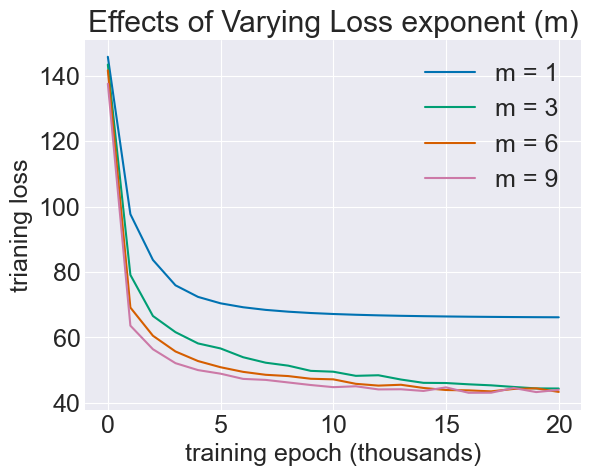

In [ ]:
# Make the the plot
plt.plot(val_loss_hist_1, label = "m = 1")
plt.plot(val_loss_hist_3, label = "m = 3")
plt.plot(val_loss_hist_6, label = "m = 6")
plt.plot(val_loss_hist_9, label = "m = 9")
plt.title("Effects of Varying Loss exponent (m)")
plt.legend()
plt.xlabel("val epoch (hundreds)")
plt.ylabel("val loss")

In [ ]:
# Effect of beta
# Effect of loss exponent beta
C = 3
M = train_samps.shape[1]

b_is_01 = NonlinearDecoder(M, C, beta = 0.01)
train_loss_hist_01, val_loss_hist_01, num_epochs_01 = b_is_01.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=2000, val_every=val_every, verbose = False, early_stopping= False)

b_is_02 = NonlinearDecoder(M, C, beta = 0.02)
train_loss_hist_02, val_loss_hist_02, num_epochs_02 = b_is_02.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=2000, val_every=val_every, verbose = False, early_stopping= False)

b_is_05 = NonlinearDecoder(M, C, beta = 0.05)
train_loss_hist_05, val_loss_hist_05, num_epochs_05 = b_is_05.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=2000, val_every=val_every, verbose = False, early_stopping= False)

b_is_1 = NonlinearDecoder(M, C, beta = 0.1)
train_loss_hist_b1, val_loss_hist_b1, num_epochs_b1 = b_is_1.fit(train_samps, train_labels, val_samps, val_labels,
                                                    batch_size=mini_batch_sz, lr=lr, max_epochs=max_epochs,
                                                    patience=2000, val_every=val_every, verbose = False, early_stopping= False)

Finished training after 2000 epochs!
Finished training after 2000 epochs!
Finished training after 2000 epochs!
Finished training after 2000 epochs!


Text(0, 0.5, 'trianing loss')

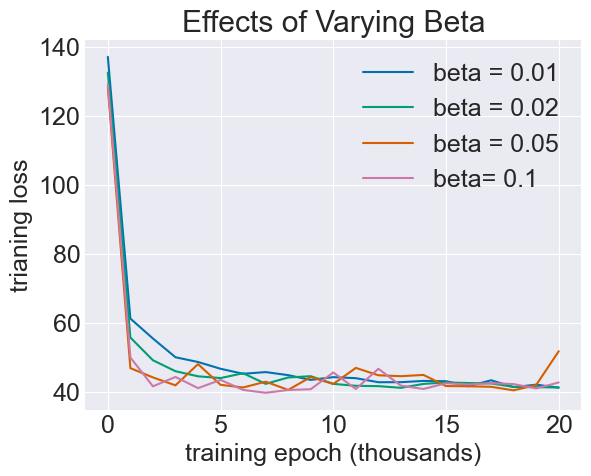

In [ ]:
# Make the the plot
# Make the the plot
plt.plot(val_loss_hist_01, label = "beta = 0.01")
plt.plot(val_loss_hist_02, label = "beta = 0.02")
plt.plot(val_loss_hist_05, label = "beta = 0.05")
plt.plot(val_loss_hist_b1, label = "beta= 0.1")
plt.title("Effects of Varying Beta")
plt.legend()
plt.xlabel("val epoch (hundreds)")
plt.ylabel("val loss")

### 3f. Questions

**Question 9:** Explain what you observe about the effect of the loss exponent `m` on the validation loss. What does it indicate about the quality and speed of learning?

**Question 10:** Explain what you observe about the effect of β on the validation loss. What does it indicate about the quality and speed of learning?

**Answer 9:** As seen from the plot above, as m is increased the quality of learning also increases since we are able to obtain a lower loss value before plateauing. As for the speed of learning is seems to stay constant since no matter the value of m we start to plateau at ~epochs.

**Answer 10:** We see that for all the values tested we do end up with good final loss but with the small value of 0.05 and large value of 0.1 we do start to see some unsmooth behavior across epochs were the loss spikes up. This it suggest that at large or small values the quality of learning is hinderd; however the speed of learning seems to be constant for the most part since all of them began to plateua at the same epoch (~300) 

## Task 4: Train and test decoders on MNIST

In [4]:
from mnist import get_mnist
from hebb_net import HebbNet

### 4a. Preparing decoder inputs

In the cell below:
1. Load the raw MNIST train/test/validation samples. Reserve 2000 training samples for validation.
2. Process them with your Competitive Hebbian Network (i.e. compute their corresponding netIn values) to get the input for your decoders.

**Tips:**
- Your Hebbian network constructor has a keyword argument that you can use to load wts from a previously trained network. You should not need to retrain your Hebbian network!
- When creating your Hebbian network object, remember to build it with the same hyperparameters as you did last week (e.g. number of neurons).

In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = get_mnist(2000)
net = HebbNet(x_train.shape[1], 500 ,inhib_value= 0.4, load_wts=True)

netIn = net.net_in(x_train)
val_netIn = net.net_in(x_val)
test_netIn = net.net_in(x_test)
netIn.shape

Loaded stored wts.


TensorShape([58000, 500])

### 4b. Linear decoder

Train your softmax classifier on the Hebbian network `net_in` activations obtained from processing the MNIST training set. The defaults should generally work fine, though here are some suggested changes to make:
1. You should probably change `val_every` so that the validation set accuracy to make it less frequent than the value used when you trained your linear decoder.
2. Feel free to change the `patience` depending on your patience :)
3. Play around with the mini-batch size. Try starting with 8192. Decrease if your GPU runs out of memory/crashes.
4. Tweak `max_epochs` so that this is not the limiting factor in your training.

#### Guidelines

- **DO NOT COPY AND PASTE HYPERPARAMETERS FROM THE IRIS TEST CODE CELLS!** They will not work well for MNIST :)
- Training should be fairly quick (no more than a few minutes).
- **Remember:** you are **NOT** training the softmax classifier **on MNIST** — you are training it on the `net_in` values produced by the Competitive Hebbian Network that you trained above!

In [9]:
Softnet = SoftmaxDecoder(netIn.shape[1], 10)
train_loss_hist, val_loss_hist, val_acc_hist = Softnet.fit(netIn, y_train, val_netIn, y_val, 8000,max_epochs=2000, patience=5, val_every=10)


epoch: 0
validation accuracy: 0.138
validation loss: 11.959313
lr: 0.0001

epoch: 10
validation accuracy: 0.1305
validation loss: 3.101814
lr: 0.0001

epoch: 20
validation accuracy: 0.205
validation loss: 2.4110386
lr: 0.0001

epoch: 30
validation accuracy: 0.321
validation loss: 1.9206593
lr: 0.0001

epoch: 40
validation accuracy: 0.453
validation loss: 1.5914102
lr: 0.0001

epoch: 50
validation accuracy: 0.5425
validation loss: 1.3672943
lr: 0.0001

epoch: 60
validation accuracy: 0.5955
validation loss: 1.2094278
lr: 0.0001

epoch: 70
validation accuracy: 0.639
validation loss: 1.0919164
lr: 0.0001

epoch: 80
validation accuracy: 0.6755
validation loss: 1.0028071
lr: 0.0001

epoch: 90
validation accuracy: 0.704
validation loss: 0.9322826
lr: 0.0001

epoch: 100
validation accuracy: 0.7265
validation loss: 0.87554497
lr: 0.0001

epoch: 110
validation accuracy: 0.7425
validation loss: 0.8285337
lr: 0.0001

epoch: 120
validation accuracy: 0.7585
validation loss: 0.7888294
lr: 0.0001

ep

### 4c: Analyze Linear Decoder performance

Create a well-labeled plot showing the training and validation loss over epochs (*note: because you likely did not check validation loss on each epoch, but "x" epoch values for each loss will likely be different. Account for this when generating "x" values used in the plot.*).

Place the accuracy of the softmax classifier on the test set in your plot title.

**NOTE:** Because the initial training and validation losses are so large compared to the final values, plotting all the values may obscure details about the eventual loss curve. I would suggest trimming training and validation loss values corresponding to the first several hundred epochs to make a better plot.

In [10]:
y_pred_linear = Softnet.predict(test_netIn)
acc_linear = Softnet.accuracy(y_test, y_pred_linear)
print(acc_linear)

0.9014


Text(0, 0.5, 'loss')

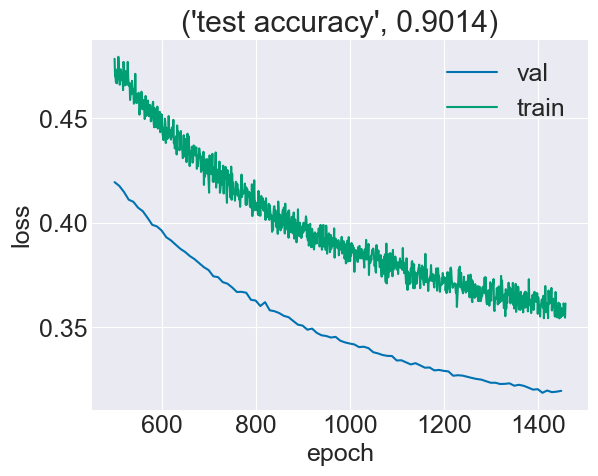

In [11]:
x = np.arange(500, 1460, 10)
x2 = np.arange(500, 1460, 1)
plt.plot(x, val_loss_hist[51:], label = "val")
plt.plot(x2, train_loss_hist[501:], label = "train")
plt.title(("test accuracy",acc_linear))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")


### 4d. Train the Nonlinear Decoder on MNIST

Repeat what you did for the softmax classifier with the nonlinear classifier.

**Note there is one additional step:** Once you get the Hebbian network `net_in` values for the train/validation/test sets, the nonlinear decoding network proposed by Krotov & Hopfield (2019) assumes that the Hebbian network `net_in` values ($h_{ij}$) that serve as the input to the decoder are transformed by the following activation function:

$$x_{ij} = max(h_{ij}, 0)^n$$

where $h_{ij}$ are the Hebbian network `net_in` values. In other words, apply ReLU to the `net_in` values then raise the result to the power `n`. By default, we assume that the hyperparameter $n=4$.

**This additional ReLU step needs to be performed on the `net_in` values representing each of the decoder train/validation/test sets!!**

Use default hyperparameters, though you may consider changing the following:

1. You should probably change `val_every` so that the validation set accuracy to make it less frequent than the value used when you trained your linear decoder.
2. Feel free to change the `patience` depending on your patience :)
3. Play around with the mini-batch size. Try starting with 8192. Decrease if your GPU runs out of memory/crashes.
4. The default max epochs should be fine, but tweak as needed.


#### Guidelines
- Training should take longer than your linear decoder, but not a lot longer (rough estimate 10-20 minutes).


In [5]:
from neural_decoder import NonlinearDecoder

In [18]:
n =4
netIn_train_NL = tf.keras.activations.relu(netIn)**n
netIn_val_NL = tf.keras.activations.relu(val_netIn)**n
netIn_test_NL = tf.keras.activations.relu(test_netIn)**n

netIn_val_NL.shape



TensorShape([2000, 500])

In [19]:
net_nonLinear = NonlinearDecoder(netIn_train_NL.shape[1], 10)

train_loss_hist, val_loss_hist, val_acc_hist = net_nonLinear.fit(netIn_train_NL, y_train, netIn_val_NL, y_val, 8000, max_epochs=2000, patience = 5, val_every=10)



epoch: 0
validation accuracy: 0.1185
validation loss: 291612.94
lr: 0.0001

epoch: 10
validation accuracy: 0.182
validation loss: 77302.06
lr: 0.0001

epoch: 20
validation accuracy: 0.2595
validation loss: 54451.21
lr: 0.0001

epoch: 30
validation accuracy: 0.3365
validation loss: 48138.53
lr: 0.0001

epoch: 40
validation accuracy: 0.38
validation loss: 44387.71
lr: 0.0001

epoch: 50
validation accuracy: 0.4065
validation loss: 42052.34
lr: 0.0001

epoch: 60
validation accuracy: 0.423
validation loss: 40447.99
lr: 0.0001

epoch: 70
validation accuracy: 0.4355
validation loss: 39419.89
lr: 0.0001

epoch: 80
validation accuracy: 0.451
validation loss: 38456.78
lr: 0.0001

epoch: 90
validation accuracy: 0.463
validation loss: 37554.258
lr: 0.0001

epoch: 100
validation accuracy: 0.477
validation loss: 36659.395
lr: 0.0001

epoch: 110
validation accuracy: 0.487
validation loss: 35905.656
lr: 0.0001

epoch: 120
validation accuracy: 0.5015
validation loss: 34969.88
lr: 0.0001

epoch: 130
va

In [21]:
y_pred_nonLinear = net_nonLinear.predict(netIn_test_NL)
acc_nonLinear = Softnet.accuracy(y_test, y_pred_nonLinear)
print(acc_nonLinear)

0.9546


### 4e: Analyze Nonlinear Decoder performance

Create a well-labeled plot showing the training and validation loss over epochs (*note: because you likely did not check validation loss on each epoch, but "x" epoch values for each loss will likely be different. Account for this when generating "x" values used in the plot.*).

Place the accuracy of the nonlinear classifier on the test set in your plot title.

**NOTE:** Because the initial training and validation losses are so large compared to the final values, plotting all the values may obscure details about the eventual loss curve. I would suggest trimming training and validation loss values corresponding to the first several hundred epochs to make a better plot.

Text(0, 0.5, 'loss')

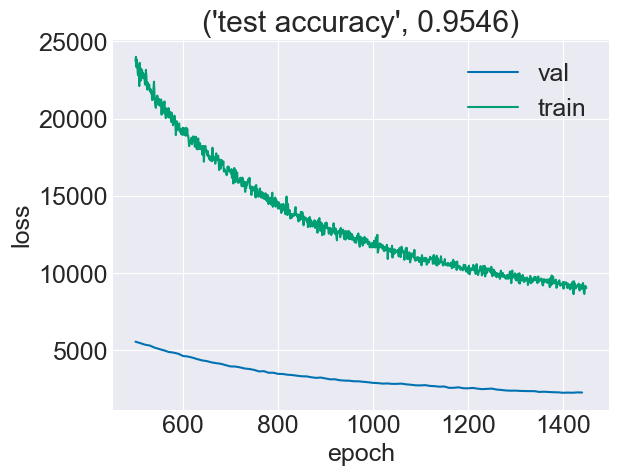

In [22]:
x = np.arange(500, 1450, 10)
x2 = np.arange(500, 1450, 1)
plt.plot(x, val_loss_hist[51:], label = "val")
plt.plot(x2, train_loss_hist[501:], label = "train")
plt.title(("test accuracy",acc_nonLinear))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

## Extensions

### 1. Compare encoder-decoder model to end-to-end training

Compare how accurately the linear and nonlinear decoders learn from raw MNIST samples compared to from the Hebbian network activations (*I would suggest keeping hyperparameters constant for a fair comparison*). There is a lot to explore here! Here are a few questions to examine:
- How rapidly do the decoders networks learn their inputs (e.g. number of training epochs needed to achieve "good" accuracy on the validation set)?
- What is the best test accuracy achieved by the decoders networks with the same hyperparameters?
- How does the decoder training times compare with the Hebbian inputs vs raw MNIST samples to achieve some level of accuracy?
- Remember that you control the dimension of the "embedding" performed by the Hebbian network (i.e. number of neurons in the net). How does the accuracy and/or training time of the decoders trade off with the Hebbian network embedding size?

### 2. Use your CS 343 Softmax network as the linear decoder

This will require a few updates to support the Adam optimizer (that you implemented in the CS 343 CNN project) and validation sets.

Copy `softmax_layer.py` from your CS343 MLP project to your working directory. Also copy `optimizer.py` from your CS343 CNN project.

Make the following changes to `fit()` in `softmax_layer.py`:
1. Switch your optimizer from SGD to Adam. This will involve creating two `Adam` objects: one for the weights, one for the bias. Also, be sure to set the Adam learning rate based on the value passed into `fit()`.
2. Add support in `fit()` for a validation set by adding the keyword arguments: `x_val=None, y_val=None`. If `verbose > 0` print out the accuracy and loss over the entire validation set. 
3. If `verbose > 0` convert your print outs to happen in terms of epochs rather than iterations (e.g. every epoch, not every 100 iterations). Add a keyword argument `val_freq=50` to specify how often (in epochs) to check and print out the validation accuracy and loss. Be sure to always print out the validation accuracy and loss on the first and last epoch regardless of the `val_freq` value.
4. Have `fit()` return both the train and validation loss as Python lists or ndarrays. In cases when you do not pass in a validation set, the returned validation loss list may be `None` and that's ok.

The network should train similarily to your Tensorflow version. Compare/analyze runtime performance.

### 3. Encode an image dataset of your choice with the Hebbian network

For example, Fashion MNIST, STL-10 or CIFAR-10. If your images contain color, I suggest either converting to grayscale or flattening the color channels when constructing your feature vectors (e.g. `(32, 32, 3)` color image made into a `(3072,)` vector). Note that color images will clearly take much longer to train.

Some areas to explore:
- Visualize the weights. Analyze how hyperparameters affect the structure.
- Compare decoding accuracy


In [6]:
import mnist 
# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

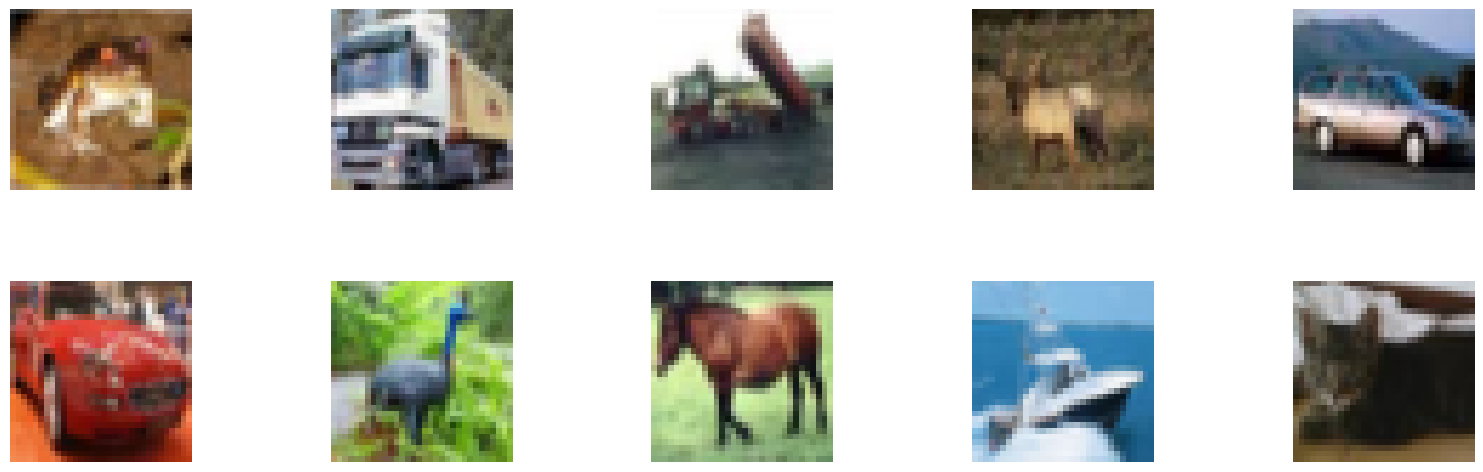

In [7]:
# plot 10 samples
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(x_train[n])
  plt.axis('off')
plt.show()

In [8]:
# convert to greyscale
x_train_grey = x_train[:, :, :, -1].squeeze()
x_test_grey = x_test[:, :, :, -1].squeeze()

print(x_train_grey.shape)

(50000, 32, 32)


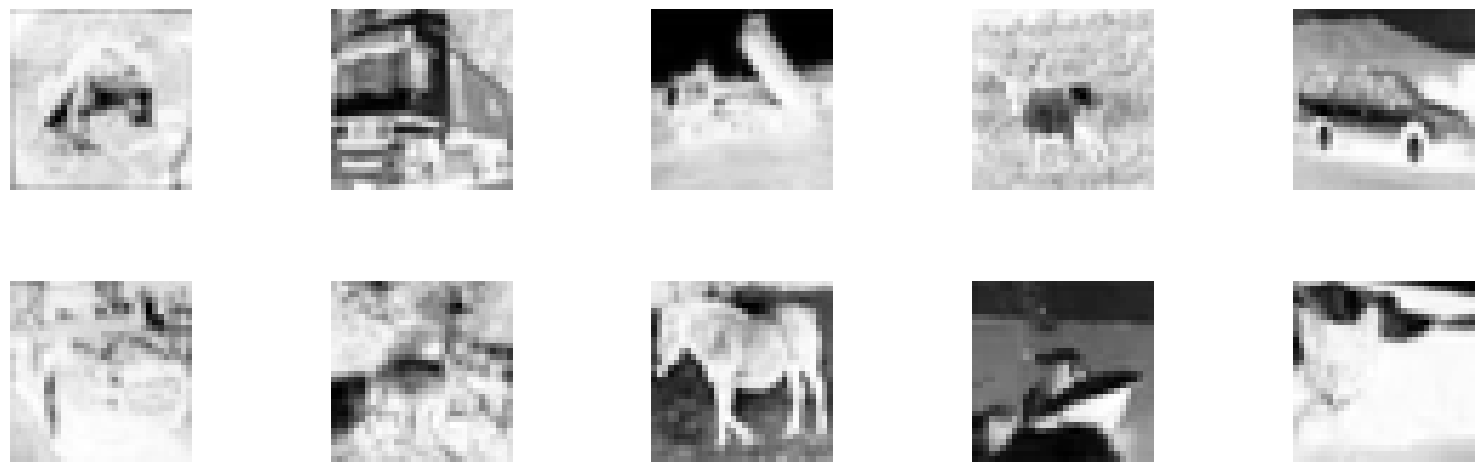

In [9]:
# plot 10 samples
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(x_train_grey[n])
  plt.axis('off')
plt.show()

In [10]:
# preprocess data
x_t,y_t,x_v, y_v = mnist.train_val_split(x_train_grey, y_train, 1000)

x_train_f = tf.constant(mnist.preprocess_mnist(x_t),tf.float32)
y_train_f = tf.constant(y_t, tf.int64)
x_val_f = tf.constant(mnist.preprocess_mnist(x_v), tf.float32)
x_test_f = tf.constant(mnist.preprocess_mnist(x_test_grey), tf.float32)
y_val_f = tf.constant(y_v, tf.int64)
y_test_f = tf.constant(y_test, tf.int64)



# test to make sure data preprocess went well
print(x_train_f.shape, x_val_f.shape, x_test_f.shape,)
print(x_train_f.dtype, x_val_f.dtype, x_test_f.dtype, y_val_f.dtype, )
print(f'Train min/max: {tf.reduce_min(x_train_f)}/{tf.reduce_max(x_train_f)}')
print(f'Validation min/max: {tf.reduce_min(x_val_f)}/{tf.reduce_max(x_val_f)}')
print(f'Test min/max: {tf.reduce_min(x_test_f)}/{tf.reduce_max(x_test_f)}')

(49000, 1024) (1000, 1024) (10000, 1024)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'> <dtype: 'int64'>
Train min/max: 0.0/1.0
Validation min/max: 0.0/1.0
Test min/max: 0.0/1.0


In [11]:
heb_net_cifar = HebbNet(1024, 500, saved_wts_path="exports/wts_cifar.npy")
heb_net_cifar.fit(x_train_f,100, 500, 1e-2, False, print_every=50)

Starting epoch 0/100
Starting epoch 50/100
Starting epoch 99/100
Saving weights...Done!


In [12]:
netIn = heb_net_cifar.net_in(x_train_f)
val_netIn = heb_net_cifar.net_in(x_val_f)
test_netIn = heb_net_cifar.net_in(x_test_f)
netIn.shape

TensorShape([49000, 500])

In [13]:
Softnet_cifar = SoftmaxDecoder(netIn.shape[1], 10)
train_loss_hist, val_loss_hist, val_acc_hist = Softnet_cifar.fit(netIn, y_train_f, val_netIn, y_val_f, 8000,max_epochs=100, patience=5, val_every=10)


epoch: 0
validation accuracy: 102.0
validation loss: [nan nan nan nan nan nan nan nan nan nan]
lr: 0.0001


KeyboardInterrupt: 

weird!!!!!!!

### 4. Learning rate decay

Krotov & Hopfield (2019) decayed the learning rate according to a epoch-based schedule for both the Hebbian network and the decoder (see their Appendix B for details). Implement this or your own variant (for either encoder and/or decoder network) and explore whether it improves decoding performance.

### 5. Hyperparameter tuning

Use a grid or random search for encoder and/decoder networks to optimize performance.

How does the number of "runner-up" neurons in the Hebbian network ($K$) influence the learned weights (visually) or the accuracy with which either decoding network decodes the correct digit?

### 6. Visualize Hebbian network activations

- Develop a way to visualize and gain a better intuition about how a Hebbian neuron's learned weights contribute to the activation across the network. One idea is to normalize each neuron's learned weights between [0, 1] (or in a way that preserves negative wts) after training. Then to visualize the contributions for a given sample `i`, scale each neuron's weights by the its netIn value to sample `i`. Draw the scaled weights using `draw_grid_image`. It might be helpful to do this for a Hebbian network with a smaller number of neurons so that you can legibly plot every neuron's weights in one plot. Analyze/interpret the relationship between this weight plot and the decoded predictions.
- Figure out how to record the "live" Hebbian training weight plots into videos for later viewing.

This are only two ideas — try out other ideas that come to mind!

### 7. Confusion matrix and error analysis of MNIST classification

For one or both classifier, make a confusion matrix of the digit classifications. Use your confusion matrix to gain insight into misclassifications. Run follow-up analyses/training sessions to explore patterns in more depth. For example, if two classes are frequently misclassified, how neurons in the Hebbian network develop receptive fields that resemble each? Are the weights resembling the two classes strongly correlated (and how?)? To what degree are inhibitory weights learned for these neurons? What happens if you train the Hebbian network on only samples belonging to the two classes — do classes of either class become less/more confusable? And so forth...

In [13]:
# confusing matrix from CS251
def confusion_matrix(y, y_pred):
        un_arr = np.unique(y)
        r = un_arr.shape[0]


        y_pred = np.array(y_pred, dtype=int)
        y = np.array(y, dtype=int)
        m = [[0] * r for i in range(r)]
        for pred, exp in zip(y_pred, y):
            m[pred][exp] += 1
        return m

In [14]:
linear_matrix = confusion_matrix(y_test, y_pred_linear)

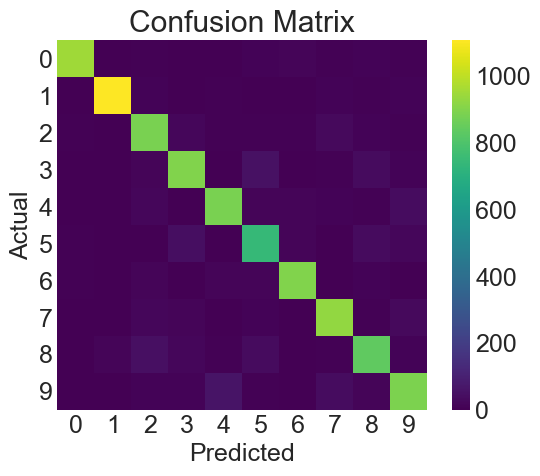

In [15]:
class_names = [str(i) for i in range(0, 10)]

#plot
plt.imshow(linear_matrix, interpolation='nearest', cmap= 'viridis')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.grid([])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print(np.array(linear_matrix))

[[ 950    0    8    4    1   11   15    5   10    7]
 [   0 1108   10    0    5    3    3    9    8   10]
 [   7    2  884   21    6    8    5   29   10    5]
 [   4    3   17  897    1   49    2    6   33    9]
 [   0    0   18    0  884   13   15   10    7   36]
 [   7    2    3   42    3  741   16    0   33   18]
 [   8    3   16    1   14   17  896    0   12    0]
 [   2    1   21   13    2    9    3  929    8   27]
 [   2   16   45   20    8   33    3    5  837    9]
 [   0    0   10   12   58    8    0   35   16  888]]


As seen from above we see that the most common mistake that the linear decoder makes is confusing a 4 with a 9 and the 2nd most common being confusing 5 with a 3. This suggest that the heb net produces similar wts between each set of these numbers to the point that the decoder sometimes is not able to tell them apart. However, it is really good at reconizing "1" from other numbers. If hebb net was trained just on those samples than I believe it would tell them apart better since it would not have to worry about discriminating against other classes.

In [24]:
nonLinear_matrix = confusion_matrix(y_test, y_pred_nonLinear)

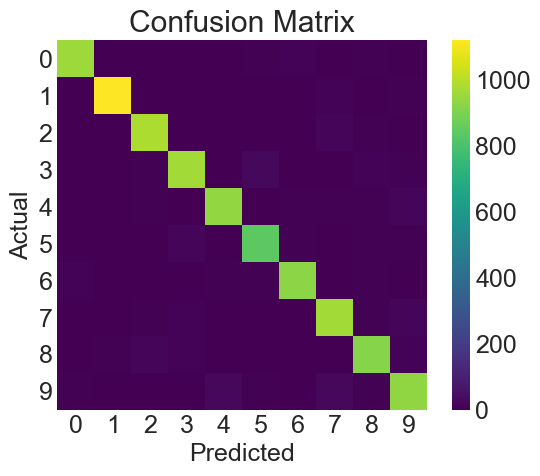

In [25]:
class_names = [str(i) for i in range(0, 10)]

#plot
plt.imshow(nonLinear_matrix, interpolation='nearest', cmap= 'viridis')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.grid([])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
print(np.array(nonLinear_matrix))

[[ 957    0    4    1    0    6    9    2    5    4]
 [   0 1120    4    0    1    2    3   10    0    6]
 [   2    1  982    4    3    4    1   15    6    1]
 [   1    3    7  966    1   22    1    2   11    7]
 [   1    0    5    1  937    4    6    7    6   19]
 [   2    0    2   15    0  839    7    0    7    6]
 [   9    3    3    0    8    7  927    0    8    2]
 [   1    0    7    9    2    0    1  964    6   15]
 [   2    8   17   12    4    3    3    2  918   13]
 [   5    0    1    2   26    5    0   26    7  936]]


Similar to the linear decoder the nonLinear's most common mistake is confusing a 4 with for a 9 but the system as a whole performs better than the Linear decoder. The 2nd most common mistake is the reverse confusing a 9 with a 4.

In [ ]:
#load data
x_train, y_train, x_test, y_test, x_val, y_val = get_mnist(2000)

# find x_train and y_train
index_of_4_y_train =  np.argwhere(y_train == 4).squeeze()
index_of_9_y_train =  np.argwhere(y_train == 9).squeeze()
print(index_of_4_y_train.shape)
samples_4_train = np.take(x_train, index_of_4_y_train, 0)
print(samples_4_train.shape)
samples_9_train = np.take(x_train, index_of_9_y_train, 0)
print(samples_4_train.shape)
x_train = np.vstack((samples_9_train, samples_4_train))
y_train = np.hstack((index_of_9_y_train, index_of_4_y_train))

# find x_val and y_val
index_of_4_y_val =np.argwhere(y_val == 4).squeeze()
index_of_9_y_val =np.argwhere(y_val == 9).squeeze()
samples_4_val = np.take(x_val, index_of_4_y_val, 0)
print(samples_4_val.shape)
samples_9_val = np.take(x_val, index_of_9_y_val, 0)
y_val = np.hstack((index_of_9_y_val, index_of_4_y_val))
x_val = np.vstack((samples_9_val, samples_4_val))

# find x_test and y_test
index_of_4_y_test =np.argwhere(y_test == 4).squeeze()
index_of_9_y_test =np.argwhere(y_test == 9).squeeze()


y_test = np.hstack((index_of_9_y_test, index_of_4_y_test))

samples_4_test = np.take(x_test, index_of_4_y_test, 0)
print(samples_4_test.shape)
samples_9_test = np.take(x_test, index_of_9_y_test, 0)
x_test = np.vstack((samples_9_test, samples_4_test))
print(x_test.shape, "hhh")
#sample smaller data_set and shuffle it 
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]

permutation2 = np.random.permutation(x_test.shape[0])
x_test = x_test[permutation2]
y_test = y_test[permutation2]

permutation3 = np.random.permutation(x_val.shape[0])
x_val = x_val[permutation3]
y_val = y_val[permutation3]

print(x_test.shape)

In [ ]:
net = HebbNet(x_train.shape[1], 500 ,inhib_value= 0.4)
net.fit(x_train, 100, 600, plot_wts_live=True)

In [ ]:
netIn = net.net_in(x_train)
val_netIn = net.net_in(x_val)
test_netIn = net.net_in(x_test)
print(test_netIn.shape)
netIn.shape

In [ ]:
Softnet_4_9 = SoftmaxDecoder(netIn.shape[1], 10)
train_loss_hist, val_loss_hist, val_acc_hist = Softnet_4_9.fit(netIn, y_train, val_netIn, y_val, 8000,max_epochs=2000, patience=100, val_every=10)

As seen from above our initial thoughts were wrong and doing a dataset with just 4s and 9s results in much more confusion or maybe I shufflied the data wrong and we are actually getting an accuracy of 100 instead of 0 b/c at the worst we should be getting around ~50% lets look at the confusing matrix for some reason the matrix function is running into an error and im not sure why; I ran out of time but I would love to explor this more in the future

In [ ]:
y_pred_linear_4_9 = Softnet_4_9.predict(test_netIn)

print(y_pred_linear_4_9.shape, y_test.shape)
linear_matrix_4_9 = confusion_matrix(y_test, y_pred_linear_4_9)
print(linear_matrix_4_9)

<!-- ### 8. Implement the Generalized Hebbian Algorithm (GHA) and compare to PCA

The GHA provides an incremental version of PCA — compute PCA one sample at a time over a number of training epochs. This approach can be helpful when you want to run PCA on a large dataset, but the dataset is too large to fit in your computer's memory (e.g. perhaps STL-10 at full 96x96 resolution). 

Implement GHA then show for a large dataset (e.g. STL-10) that GHA computes the PCA representation, whereas regular PCA (e.g. from CS251/2) fails. Plot what the image samples look like over training epochs when projected to PCA space and then back to the original data space (i.e. filtered by the learned principle components / network weights). If this sounds interesting, please see me for guidance. -->

### 8. Experiment with different decoder architectures

Create one or more different nonlinear decoders in TensorFlow (e.g. MLP, CNN). Compare performance/accuracy with the nonlinear one in the project.

### 9. Tuning Hebbian network

Krotov & Hopfield (2019) used 2000 neurons in their Competitive Hebbian Network to get the results that they did and some different hyperparameters. We used 500 to make things run faster / take less memory. Experiment with how the Hebbian network hyperparameters (number of neurons, which neuron gets inhibited, inhibition strength, etc.) affect encoding of the MNIST digits and decoding accuracy.

### 10. Explore effect of Ɣ on activation convergence in the Contrastive Hebbian Network.

### 11. Visualize the receptive fields of neurons in the Contrastive Hebbian Network

Use gradient ascent (i.e. Deep Dream): feed in single random noise image sample (cast as a `tf.Variable`) to the network while tracking gradients. Just like Deep Dream treat the neuron's `net_act` whose receptive field you'd like to visualize as the loss and iteratively change the noise image using the image gradient `d_img` to maximize the neuron's `net_act`. You will need to use a learning rate, epochs, and so forth. You will end up with an image that maximally activates the neuron you are probing.

### Extension 2: Returning to Segmentation from last semester

We want to build a semantic segmentation network.  Let us first pick our data and decide the problem we are trying to solve.  To keep data small, we will have only 2 classes.  Additionally, we want to use some dataset which is fairly simple and low resolution. For now, let's aim for somewhere between 16x16 and 28x28.  There's a lot of good options with these parameters.  Let's take a closer look at some of our options:

I decided on using MNIST due to the ease of use.  We now need 2 things, the MNIST dataset and masks for each entry in the dataset.

We want to get MNIST as normal and then threshold it across some reasonable value to generate the mask. 

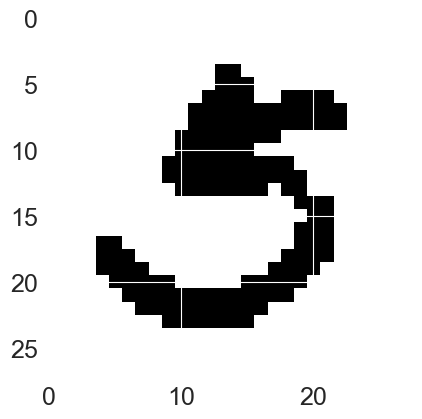

In [75]:
import numpy as np
x_val = tf.reshape(x_val, (x_val.shape[0],28,28,1))
x_train = tf.reshape(x_train, (x_train.shape[0],28,28,1))
y_masks = np.zeros_like(x_train, dtype = np.int32)
y_masks[x_train > 0.5] = 1.0
plt.imshow(y_masks[0].reshape(28,28))

y_val_masks = np.zeros_like(x_val, dtype = np.int32)
y_val_masks[x_val > 0.5] = 1.0


Now that we have the data that we will use, we can build our segmentation network accordingly.

For ease of implementation, let's use Keras.

Let's discuss the architecture for a moment. 

We are looking to create segmentation from 28x28 images, meaning that we likely cannot convolve too many times as the loss of dimensionality will be too great.  Unscientifically, I would guess that more than 3 convolution/max-pooling layers in the encoder would be too many.

We will start with 2 layers in the encoder, which means to return to original resolution we would need 2 in the decoder. 

Additionally, I imagine using convolutional units that contain max pooling layers would make sense as well since we saw how much that helped in the first semester. 

In terms of activation, there's no reason not to use relu for the hidden layers.  Additioanlly, because we are doing binary classification we can use sigmoid in the output layer.

This lays out most of what we are doing.  

Let us also figure out how many filters to use for the first layer, the rest will just be determined from this value. 

It makes sense to use some power of 2 first.  Let's start with 16.  This means in the next layer it will be 32, then 32 again as we start to decode, then 16 again in the last convolutional layer in the decoder. 

After reading a bit more, I know that we want to convolve after upsampling, this is where the magic happens with semantic segmentation. 

Let's implement this. 

In [76]:
from keras import layers, models

def simple_binary_semantic_segmentation(data_shape):
    #encoder

    #unit 1
    input_layer = tf.keras.Input(shape = data_shape)
    u1_conv = layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu')(input_layer)
    u1_pool = layers.MaxPool2D(pool_size = (2,2))(u1_conv)
    #unit 2
    u2_conv = layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu')(u1_pool)
    u2_pool = layers.MaxPool2D(pool_size = (2,2))(u2_conv)

    #decoder

    #unit 3
    u3_conv = layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu')(u2_pool)
    u3_convT = layers.UpSampling2D((2,2))(u3_conv)
    #unit 4
    u4_conv = layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu')(u3_convT)
    u4_convT = layers.UpSampling2D((2,2))(u4_conv)

    output_layer = layers.Conv2D(1, (3,3), padding = 'same',activation = 'sigmoid')(u4_convT)

    model = models.Model(inputs = input_layer, outputs = output_layer)
    return model


In [77]:
#run the model on our data

mnist_segmentor = simple_binary_semantic_segmentation((x_train.shape[1:]))
mnist_segmentor.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])
mnist_segmentor.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 7, 7, 32)          9248

#### Train the model

In [79]:
hist = mnist_segmentor.fit(x_train,y_masks,batch_size = 72, epochs = 1, validation_data = (x_val, y_val_masks))

806/806 [==============================] - 64s 79ms/step - loss: 0.0526 - accuracy: 0.9781 - val_loss: 0.0411 - val_accuracy: 0.9829


63/63 [==============================] - 1s 9ms/step - loss: 0.0411 - accuracy: 0.9829
[0.04110706225037575, 0.982912003993988]
63/63 [==============================] - 1s 7ms/step


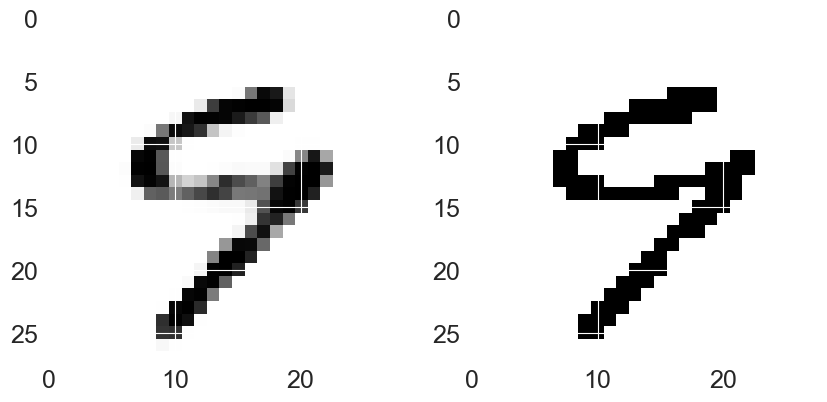

In [80]:
#evaluate model 
#note that we'd normally use a test set here but I didn't
print(mnist_segmentor.evaluate(x_val, y_val_masks))
prediction = mnist_segmentor.predict(x_val)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(prediction[0])
axs[1].imshow(y_val_masks[0])

98% accuracy is very good, but this may be misleading. Because there are so many more "blank" pixels, its very easy to get a high accuracy.  We can account for this by calculating a different metric, IoU.

IoU stands for Intersection over Union and is a popular metric for evaluating segmentation models. 

This can be written as: 

$\frac{{\left| A \cap B \right|}}{{\left| A \cup B \right|}}$

In [81]:
#NOTE THIS IS NOT MY CODE, I GOT THIS FROM https://stackoverflow.com/questions/65974208/intersection-over-union-iou-metric-for-multi-class-semantic-segmentation-task

#I AM NOT LOOKING TO GET CREDIT FOR IMPLEMENTING MEAN IOU, JUST FOR USING IT TO MAKE INTERPRETATIONS ABOUT MY MODEL

def mean_iou(y_true, y_pred):
    y_pred = tf.round(tf.cast(y_pred, tf.int32))
    intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
    union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


In [82]:
#recompile and fit using mean_iou as a metric,

mnist_segmentor = simple_binary_semantic_segmentation((x_train.shape[1:]))
mnist_segmentor.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy', mean_iou])
mnist_segmentor.summary()
hist = mnist_segmentor.fit(x_train,y_masks,batch_size = 72, epochs = 1, validation_data = (x_val, y_val_masks))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 7, 7, 32)          924

In [83]:
#and we reassess our performance: 

print(mnist_segmentor.evaluate(x_val, y_val_masks))

63/63 [==============================] - 1s 11ms/step - loss: 0.0422 - accuracy: 0.9825 - mean_iou: 0.5575
[0.04224603250622749, 0.9824878573417664, 0.5575387477874756]


So we get a val loss of 0.04 and accuracy of 0.98 which is considered fantastic, however using a better metric for our dataset and problem, we get a mean iou of 0.5575.  This is considered good, but not groundbreaking by any means.  This shows us that our model is working though!

In the future we could train for more epochs to get better performance, build a slightly larger network, or experiment with more or less filters.  Overall this was a worthwhile investigation into another encoder-decoder network.